In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, classification_report
from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
fer_directory = 'data/FER2013'
ck_directory = 'data/CK+'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensorflow version: 2.10.1
Num GPUs Available:  1


In [6]:
def test_model(y_true, y_pred, classes):
    # Calculate metrics
    print(classification_report(y_true, np.argmax(y_pred, axis=1), target_names=classes))

    # Calculate Precision, Recall, F1 score
    precision, recall, fscore, support = precision_recall_fscore_support(y_true, np.argmax(y_pred, axis=1), average='macro')
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", fscore)
    
    return precision, recall, fscore

def plot_confusion_matrix(y_true, y_pred, classes):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.show()

<h2>Pre processing with data augmentation</h2>

In [13]:
# Initialise generator with rescale factor 1./255
train_gen = ImageDataGenerator(rescale=1./255, rotation_range=10,  zoom_range=0.1, horizontal_flip=True, validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255, rotation_range=10, zoom_range=0.1, horizontal_flip=True)

# Preprocess training set
train_generator = train_gen.flow_from_directory(
    fer_directory + '/train',
    target_size=(48,48),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_gen.flow_from_directory(
    fer_directory + '/train',
    target_size=(48,48),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Preprocess test set
# False shuffle so classification dont get mixed
test_generator = test_gen.flow_from_directory(
    fer_directory + '/test',
    target_size=(48,48),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [14]:
# Get steps per epoch
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# Get classes and y labels
classes = list(test_generator.class_indices.keys())
y_true = test_generator.classes

<h1>First Model Run</h1>

In [10]:
# Define model
first_model = Sequential()

# 1st convolution layer
first_model.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)))
first_model.add(BatchNormalization())
first_model.add(Activation('relu'))
first_model.add(MaxPooling2D(pool_size=(2,2)))
first_model.add(Dropout(0.25))

# 2nd convolution layer
first_model.add(Conv2D(128, (5,5), padding='same'))
first_model.add(BatchNormalization())
first_model.add(Activation('relu'))
first_model.add(MaxPooling2D(pool_size=(2,2)))
first_model.add(Dropout(0.25))

# 3rd convolution layer
first_model.add(Conv2D(512, (3,3), padding='same'))
first_model.add(BatchNormalization())
first_model.add(Activation('relu'))
first_model.add(MaxPooling2D(pool_size=(2,2)))
first_model.add(Dropout(0.25))

# Flatten and feed into dense layer
first_model.add(Flatten())
first_model.add(Dense(256))
first_model.add(BatchNormalization())
first_model.add(Activation('relu'))
first_model.add(Dropout(0.25))

# Output layer
first_model.add(Dense(7, activation='softmax'))

# Compile model
first_model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
first_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_5 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 128)      

In [11]:
# Plots image
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
# Image('model.png',width=400, height=200)

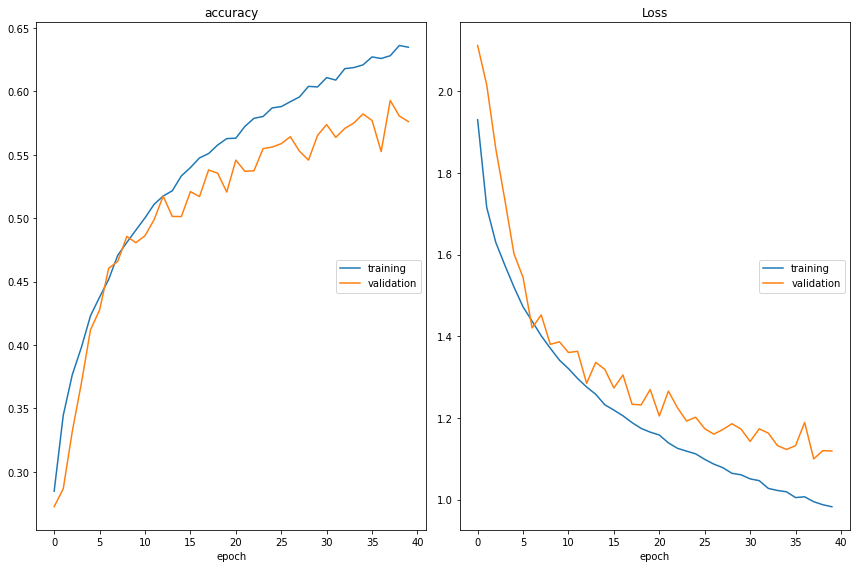

accuracy
	training         	 (min:    0.285, max:    0.636, cur:    0.635)
	validation       	 (min:    0.272, max:    0.593, cur:    0.576)
Loss
	training         	 (min:    0.982, max:    1.931, cur:    0.982)
	validation       	 (min:    1.100, max:    2.113, cur:    1.119)
179/179 [==============================] - 26s 143ms/step - loss: 0.9824 - accuracy: 0.6349 - val_loss: 1.1190 - val_accuracy: 0.5762


In [4]:
# Train model
epochs = 40
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# Reduce learning rate when a metric has stopped improving
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, mode='auto')

# Stop training when val loss has stopped improving
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Save model weights
checkpoint = ModelCheckpoint('weights/model_weights_first.h5', monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)

# Train model
history = first_model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stop, PlotLossesKeras()],
)

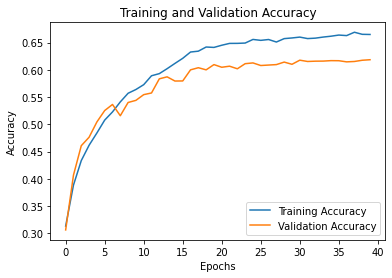

In [ ]:
# Plot training and validation accuracy and loss
plt.figure(facecolor='white')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('graphs/accuracy_first_model.png')
plt.show()

In [16]:
# Test model
first_model.load_weights('weights/model_weights_first.h5')
first_model_accuracy = first_model.evaluate(test_generator)
first_model_y_pred = first_model.predict(test_generator)

57/57 [==============================] - 7s 129ms/step


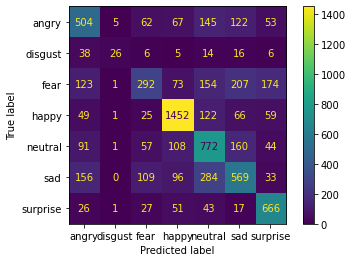

In [17]:
# Plot confusion matrix
cm = confusion_matrix(test_generator.classes, np.argmax(first_model_y_pred, axis=1))
cm_display = ConfusionMatrixDisplay(cm, display_labels=classes)
cm_display.plot()

In [18]:
# Calculate metrics
first_model_precision, first_model_recall, first_model_fscore = test_model(y_true, first_model_y_pred, classes)

              precision    recall  f1-score   support

       angry       0.51      0.53      0.52       958
     disgust       0.74      0.23      0.36       111
        fear       0.51      0.29      0.36      1024
       happy       0.78      0.82      0.80      1774
     neutral       0.50      0.63      0.56      1233
         sad       0.49      0.46      0.47      1247
    surprise       0.64      0.80      0.71       831

    accuracy                           0.60      7178
   macro avg       0.60      0.54      0.54      7178
weighted avg       0.59      0.60      0.59      7178

Precision: 0.597318550544868
Recall: 0.5354043036028758
F1 Score: 0.5407217537669641


<h1>Model with hyperparameter optimisation</h1>

In [16]:
# First Model Optimised
# Define model
first_model_optimised = Sequential()

# 1st convolution layer
first_model_optimised.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)))
first_model_optimised.add(BatchNormalization())
first_model_optimised.add(Activation('relu'))
first_model_optimised.add(MaxPooling2D(pool_size=(2,2)))
first_model_optimised.add(Dropout(0.25))

# 2nd convolution layer
first_model_optimised.add(Conv2D(320, (5,5), padding='same'))
first_model_optimised.add(BatchNormalization())
first_model_optimised.add(Activation('relu'))
first_model_optimised.add(MaxPooling2D(pool_size=(2,2)))
first_model_optimised.add(Dropout(0.25))

# 3rd convolution layer
first_model_optimised.add(Conv2D(512, (3,3), padding='same'))
first_model_optimised.add(BatchNormalization())
first_model_optimised.add(Activation('relu'))
first_model_optimised.add(MaxPooling2D(pool_size=(2,2)))
first_model_optimised.add(Dropout(0.25))

# Flatten and feed into dense layer
first_model_optimised.add(Flatten())
first_model_optimised.add(Dense(512))
first_model_optimised.add(BatchNormalization())
first_model_optimised.add(Activation('relu'))
first_model_optimised.add(Dropout(0.3))

# Output layer
first_model_optimised.add(Dense(7, activation='softmax'))

# Compile model
first_model_optimised.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
first_model_optimised.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_10 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 24, 24, 320)      

In [17]:
# Train model
epochs = 40
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# Reduce learning rate when a metric has stopped improving
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, mode='auto')

# Stop training when val loss has stopped improving
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Save model weights
checkpoint = ModelCheckpoint('weights/model_weights_first_optimised.h5', monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)

# Train model
history = first_model_optimised.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stop, PlotLossesKeras()],
)

Epoch 1/40
 16/179 [=>............................] - ETA: 29s - loss: 2.2802 - accuracy: 0.2051

KeyboardInterrupt: 

In [ ]:
# Plot training and validation accuracy and loss
plt.figure(facecolor='white')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')

In [ ]:
# Test model
first_model_optimised.load_weights('weights/model_weights_first_optimised.h5')
first_model_optimised_accuracy = first_model_optimised.evaluate(test_generator)
first_model_optimised_y_pred = first_model_optimised.predict(test_generator)

In [ ]:
# Plot confusion matrix
cm = plot_confusion_matrix(y_true, first_model_optimised_y_pred, classes)

In [ ]:
# Calculate metrics
first_model_optimised_precision, first_model_optimised_recall, first_model_optimised_fscore = test_model(y_true, first_model_optimised_y_pred, classes)

<h1>New Model</h1>

In [10]:
# Reference model
ref_model = Sequential()

ref_model.add(Conv2D(256, (3,3), padding='same', input_shape=(48,48,1), activation='relu'))
ref_model.add(Conv2D(516, (3,3), padding='same', activation='relu'))
ref_model.add(BatchNormalization())
ref_model.add(MaxPooling2D(pool_size=(2,2)))
ref_model.add(Dropout(0.4))

ref_model.add(Conv2D(384, (3,3), padding='same', activation='relu'))
ref_model.add(BatchNormalization())
ref_model.add(MaxPooling2D(pool_size=(2,2)))
ref_model.add(Dropout(0.4))

ref_model.add(Conv2D(192, (3,3), padding='same', activation='relu'))
ref_model.add(BatchNormalization())
ref_model.add(MaxPooling2D(pool_size=(2,2)))
ref_model.add(Dropout(0.4))

ref_model.add(Conv2D(384, (3,3), padding='same', activation='relu'))
ref_model.add(BatchNormalization())
ref_model.add(MaxPooling2D(pool_size=(2,2)))
ref_model.add(Dropout(0.4))

ref_model.add(Flatten())
ref_model.add(Dense(256, activation='relu'))
ref_model.add(BatchNormalization())

ref_model.add(Dropout(0.3))
ref_model.add(Dense(7, activation='softmax'))

ref_model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
ref_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 516)       1189380   
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 516)      2064      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 516)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 516)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 384)       1

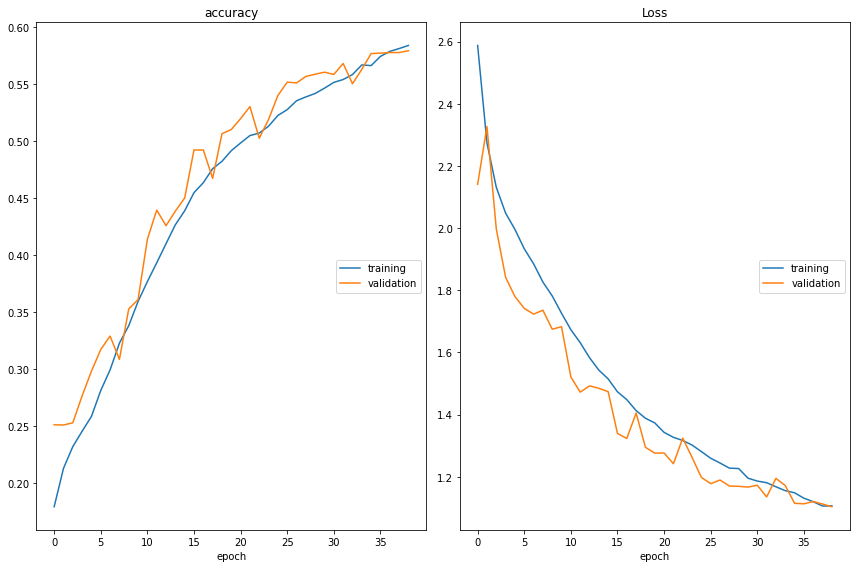

accuracy
	training         	 (min:    0.180, max:    0.584, cur:    0.584)
	validation       	 (min:    0.251, max:    0.579, cur:    0.579)
Loss
	training         	 (min:    1.106, max:    2.588, cur:    1.106)
	validation       	 (min:    1.103, max:    2.327, cur:    1.103)
179/179 [==============================] - 600s 3s/step - loss: 1.1062 - accuracy: 0.5840 - val_loss: 1.1034 - val_accuracy: 0.5794
Epoch 40/40
 14/179 [=>............................] - ETA: 4:50 - loss: 1.1020 - accuracy: 0.5837

KeyboardInterrupt: 

In [21]:
# Train model
epochs = 40
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00001, mode='auto')

# Stop training when val loss has stopped improving
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# Save model weights
checkpoint = ModelCheckpoint('weights/model_weights_ref.h5', monitor='val_accuracy', save_weights_only=True, mode='max', verbose=2)

# Train model
history = ref_model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stop, PlotLossesKeras()],
)

In [ ]:
# Plot training and validation accuracy and loss
plt.figure(facecolor='white')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('graphs/accuracy_ref_model.png')
plt.show()


accuracy
	training         	 (min:    0.180, max:    0.581, cur:    0.581)
	validation       	 (min:    0.251, max:    0.578, cur:    0.578)
Loss
	training         	 (min:    1.106, max:    2.588, cur:    1.106)
	validation       	 (min:    1.112, max:    2.327, cur:    1.112)

In [11]:
# Evaluate Model
ref_model.load_weights('weights/model_weights_ref.h5')
ref_model.evaluate(test_generator)
ref_model_y_pred = ref_model.predict(test_generator, test_generator.n//test_generator.batch_size+1)

57/57 [==============================] - 9s 158ms/step


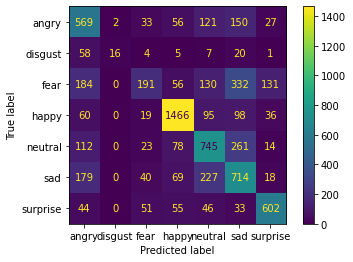

In [12]:
# Confusion Matrix
plot_confusion_matrix(y_true, ref_model_y_pred, classes)


In [21]:
# Calculate metrics
ref_model_precision, ref_model_recall, ref_model_fscore = test_model(y_true, ref_model_y_pred, classes)

              precision    recall  f1-score   support

       angry       0.47      0.59      0.52       958
     disgust       0.80      0.14      0.24       111
        fear       0.53      0.19      0.27      1024
       happy       0.82      0.82      0.82      1774
     neutral       0.52      0.59      0.56      1233
         sad       0.44      0.56      0.49      1247
    surprise       0.73      0.73      0.73       831

    accuracy                           0.59      7178
   macro avg       0.61      0.52      0.52      7178
weighted avg       0.60      0.59      0.58      7178

Precision: 0.614633704574082
Recall: 0.5167354458668455
F1 Score: 0.5192194804626155


<h2>New Model with hyper parameters optimised</h2>

In [15]:
# Define new model with optimised parameters
# Reference model
ref_model_optimised = Sequential()

ref_model_optimised.add(Conv2D(256, (3,3), padding='same', input_shape=(48,48,1), activation='relu'))
ref_model_optimised.add(Conv2D(384, (3,3), padding='same', activation='relu'))
ref_model_optimised.add(BatchNormalization())
ref_model_optimised.add(MaxPooling2D(pool_size=(2,2)))
ref_model_optimised.add(Dropout(0.3))

ref_model_optimised.add(Conv2D(320, (3,3), padding='same', activation='relu'))
ref_model_optimised.add(BatchNormalization())
ref_model_optimised.add(MaxPooling2D(pool_size=(2,2)))
ref_model_optimised.add(Dropout(0.3))

ref_model_optimised.add(Conv2D(192, (3,3), padding='same', activation='relu'))
ref_model_optimised.add(BatchNormalization())
ref_model_optimised.add(MaxPooling2D(pool_size=(2,2)))
ref_model_optimised.add(Dropout(0.3))

ref_model_optimised.add(Conv2D(192, (3,3), padding='same', activation='relu'))
ref_model_optimised.add(BatchNormalization())
ref_model_optimised.add(MaxPooling2D(pool_size=(2,2)))
ref_model_optimised.add(Dropout(0.3))

ref_model_optimised.add(Flatten())
ref_model_optimised.add(Dense(352, activation='relu'))
ref_model_optimised.add(BatchNormalization())

ref_model_optimised.add(Dropout(0.1))
ref_model_optimised.add(Dense(7, activation='softmax'))

ref_model_optimised.compile(optimizer=Adam(learning_rate=0.001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
ref_model_optimised.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 48, 48, 256)       2560      
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 384)       885120    
                                                                 
 batch_normalization_5 (Batc  (None, 48, 48, 384)      1536      
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 384)      0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 384)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 320)      

In [19]:
# Train model
epochs = 40

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00001, mode='auto')

# Stop training when val loss has stopped improving
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# Save model weights
checkpoint = ModelCheckpoint('weights/model_weights_ref_optimised.h5', monitor='val_accuracy', save_weights_only=True, mode='max', verbose=2)

history = ref_model_optimised.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stop, PlotLossesKeras()],
)

Epoch 1/40
 21/179 [==>...........................] - ETA: 47s - loss: 2.5486 - accuracy: 0.1730

KeyboardInterrupt: 

In [ ]:
# Plot training and validation accuracy and loss
plt.figure(facecolor='white')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('graphs/accuracy_ref_model_optimised.png')
plt.show()

In [ ]:
# Evaluate Model
ref_model_optimised.load_weights('weights/model_weights_ref_optimised.h5')
ref_model_optimised.evaluate(test_generator)
ref_model_optimised_y_pred = ref_model_optimised.predict(test_generator, test_generator.n//test_generator.batch_size+1)

In [ ]:
# Confusion Matrix
plot_confusion_matrix(y_true, ref_model_optimised_y_pred, classes)

In [ ]:
# Calculate metrics
ref_model_optimised_precision, ref_model_optimised_recall, ref_model_optimised_fscore = test_model(y_true, ref_model_optimised_y_pred, classes)